<div align="right" style="text-align: right">
<i>TTK21 lecture 2 - 3D geometry<br>September 2021</i>
</div>

# Exercise 1: Poses and cameras
We will in this exercise play around with 3D poses and the perspective camera model.
To make this even more fun, I have created [visgeom](https://github.com/tussedrotten/visgeom), a small library you can use to visualise poses and cameras.

We can start by plotting the world frame $\mathcal{F}_w$, which is just the origin in our 3D world:

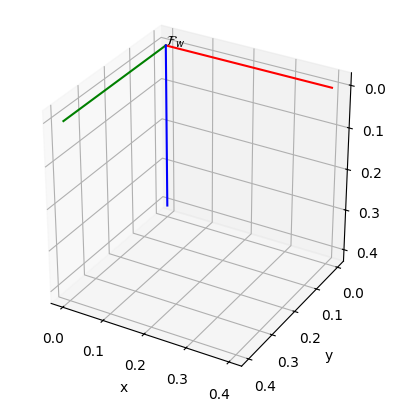

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import visgeom as vg

# Create figure and axis.
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Plot the pose of the world frame (relative to the world frame).
R_w_w = np.identity(3)
t_w_w = np.zeros((3, 1))
vg.plot_pose(ax, (R_w_w, t_w_w), scale=0.4, text='$\mathcal{F}_w$')

# Show figure.
vg.plot.axis_equal(ax)
ax.invert_zaxis()
ax.invert_yaxis()
plt.show()

We will assume that the world frame is a NED coordinate frame (notice that the $z$-axis is pointing downwards).
The pose of the world frame is here represented as the tuple `(R_w_w, t_w_w)`, where `R_w_w` is the rotation matrix describing the orientation, and `t_w_w` is the translation vector.
You can find documentation for the `visgeom` functions in the [source files](https://github.com/tussedrotten/visgeom).

## Ex 1.1: Implement classes for rotations and poses
Instead of working on these pose tuples `(R, t)`, it will be more convenient to write classes that represents the rotations $\mathbf{R} \in SO(3)$ and poses $\mathbf{T} \in SE(3)$.

Carefully read the code below and finish the classes `Rot3` and `Pose3`.
Make sure to implement the operations *composition*, *inverse* and *action on points*, for $SO(3)$ and $SE(3)$.
Each place you need to add code should be clearly marked with `# TODO:`.

In [5]:
from scipy.spatial.transform import Rotation

class Rot3:
    """Represents an element of the SO(3) Lie group (rotations in 3D)."""

    def __init__(self, R=np.identity(3)):
        """Constructs an SO(3) element.
        The default is the identity element.
        Other 3x3 matrices R are fitted to the closest matrix on SO(3).

        :param R: A 3x3 rotation matrix (optional).
        """
        if R is self.__init__.__defaults__[0]:
            # Default argument is identity.
            # Set property directly, since guaranteed SO(3).
            self._matrix = np.identity(3)
        else:
            # Argument should be some 3x3 matrix.
            # Fit to SO(3).
            self.matrix = R

    @property
    def matrix(self):
        """ The matrix representation of the SO(3) element

        :return: 3x3 rotation matrix corresponding to this SO(3) element.
        """
        return self._matrix

    @matrix.setter
    def matrix(self, R):
        """Sets the matrix to the closest element on SO(3)

        :param R: 3x3 matrix
        """
        # This is slower than necessary, but ensures correct representation.
        self._matrix = Rot3.to_so3_matrix(R)

    @staticmethod
    def to_so3_matrix(R):
        """Fits an arbitrary 3x3 matrix to the closest element on SO(3)

        :param R: An arbitrary 3x3 matrix
        :return: The closest valid 3x3 rotation matrix
        """
        # From Zhangs paper 
        if not (isinstance(R, np.ndarray) and R.shape == (3, 3)):
            raise TypeError('Argument must be a 3x3 matrix')

        u, s, v = np.linalg.svd(R)
        R = u.dot(v)

        if np.linalg.det(R) < 0:
            R = -R

        return R

    @classmethod
    def from_angle_axis(cls, angle, axis):
        """Construct an SO(3) element corresponding to a rotation around a specified axis.

        :param angle: Rotation angle in radians.
        :param axis: Rotation axis as a unit 3d column vector.
        :return: The SO(3) element.
        """
        # Guaranteed to be SO(3), so set property directly.
        rot3 = cls()
        rot3._matrix = Rotation.from_rotvec(angle * axis.flatten()).as_matrix()
        return rot3

    @classmethod
    def rot_x(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the x-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[1, 0, 0]]).T)

    @classmethod
    def rot_y(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the y-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[0, 1, 0]]).T)

    @classmethod
    def rot_z(cls, angle):
        """Construct an SO(3) element corresponding to a rotation around the z-axis.

        :param angle: Rotation angle in radians.
        :return: The SO(3) element.
        """
        return cls.from_angle_axis(angle, np.array([[0, 0, 1]]).T)

    @classmethod
    def from_roll_pitch_yaw(cls, roll, pitch, yaw):
        """Construct an SO(3) element from Z-Y-X Euler angles.

        :param roll: Rotation angle around the x-axis in radians.
        :param pitch: Rotation angle around the y-axis in radians.
        :param yaw: Rotation angle around the z-axis in radians.
        :return: The SO(3) element.
        """
        # Guaranteed to be SO(3) through composition, so set property directly.
        rot3 = cls()
        rot3._matrix = (Rot3.rot_z(yaw) * Rot3.rot_y(pitch) * Rot3.rot_x(roll)).matrix
        return rot3

    def compose(self, Y):
        """Compose this element with another element on the right

        :param Y: The other Rot3 element
        :return: This element composed with Y
        """
        composed_element = Rot3()
        composed_element._matrix = self.matrix.dot(Y.matrix) 
        return composed_element
    
    def inverse(self):
        """Compute the inverse of the current element X.

        :return: The inverse of the current element.
        """
        # The transpose is guaranteed to be SO(3), update the property directly.
        X_inv = Rot3()

        # TODO: Compute correct matrix for inverse!
        X_inv._matrix = self.matrix.T
        return X_inv

    def action(self, x):
        """Perform the action of the SO(3) element on the 3D column vector x.

        :param x: 3D column vector to be transformed
        :return: The resulting rotated 3D column vector
        """

        x = self.matrix.dot(x)
        return x

    def __mul__(self, other):
        """Multiplication operator performs composition on elements of SO(3) and action on vectors.

        :param other: Rot3 or 3D column vector
        :return: Composition for Rot3, or action for 3D column vector
        """
        if isinstance(other, np.ndarray) and other.shape == (3, 1):
            # Other is 3D column vector, perform action on vector.
            return self.action(other)
        elif isinstance(other, Rot3):
            # Other is Rot3, perform composition.
            return self.compose(other)
        else:
            raise TypeError('Argument must be a 3D column vector or a Rot3')


In [6]:
class Pose3:
    """Represents an element of the SE(3) Lie group (poses in 3D)."""

    def __init__(self, pose_tuple=(Rot3(), np.zeros((3, 1)))):
        """Constructs an SE(3) element.
        The default is the identity element.

        :param pose_tuple: A tuple (rot3, t) (optional).
        """
        self.rotation, self.translation = pose_tuple

    @property
    def rotation(self):
        """ The Rot3 rotation, an element of SO(3)

        :return: A Rot3 object corresponding to the orientation.
        """
        return self._rotation

    @rotation.setter
    def rotation(self, rot3):
        """Sets the rotation

        :param rot3: A Rot3
        """
        if not isinstance(rot3, Rot3):
            raise TypeError('Rotation must be a Rot3')

        self._rotation = rot3

    @property
    def translation(self):
        """The translation, a 3D column vector

        :return: A 3D column vector corresponding to the translation.
        """
        return self._translation

    @translation.setter
    def translation(self, t):
        """Sets the translation

        :param t: 3D column vector
        """
        if not isinstance(t, np.ndarray) and t.shape == (3, 1):
            raise TypeError('Translation must be a 3D column vector')

        self._translation = t

    def to_matrix(self):
        """Return the matrix representation of this pose.

        :return: 4x4 SE(3) matrix
        """
        T = np.identity(4)
        T[0:3, 0:3] = self.rotation.matrix
        T[0:3, 3] = self.translation.T
        return T

    def to_tuple(self):
        """Return the tuple representation of this pose

        :return: (R (3x3 matrix), t (3D column vector)
        """
        return (self.rotation.matrix, self.translation)

    def compose(self, Y):
        """Compose this element with another element on the right

        :param Y: The other Pose3 element
        :return: This element composed with Y
        """
        composed_element = Pose3()
        composed_element._rotation = self.rotation.compose(Y.rotation)
        composed_element._translation = self.translation + self.rotation.action(Y.translation)

        return composed_element

    def inverse(self):
        """Compute the inverse of the current element X.

        :return: The inverse of the current element.
        """
        inverse_pose = Pose3()
        inverse_pose._rotation = self.rotation.inverse()
        inverse_pose._translation = -inverse_pose.rotation.action(self.translation)

        return inverse_pose

    def action(self, x):
        """Perform the action of the SE(3) element on the 3D column vector x.

        :param x: 3D column vector to be transformed
        :return: The resulting rotated and translated 3D column vector
        """

        x = self.rotation.action(x) + self.translation

        return x

    def __mul__(self, other):
        """Multiplication operator performs composition on elements of SE(3) and action on vectors.

        :param other: Pose3 or 3D column vector
        :return: Composition for Pose3, or action for 3D column vector
        """
        if isinstance(other, np.ndarray) and other.shape == (3, 1):
            # Other is 3D column vector, perform action on vector.
            return self.action(other)
        elif isinstance(other, Pose3):
            # Other is Pose3, perform composition.
            return self.compose(other)
        else:
            raise TypeError('Argument must be a 3D column vector or a Pose3')

When you are finished with the `Rot3`and `Pose3` classes, the following code should work.

(If you weren't able to finish the code above, you can use [pylie](https://github.com/tussedrotten/pylie) instead.
Use [`SO3`](https://github.com/tussedrotten/pylie/blob/master/pylie/so3.py) for `Rot3` and
[`SE3`](https://github.com/tussedrotten/pylie/blob/master/pylie/se3.py) for `Pose3`)

In [12]:
# Construct a few relative poses.
pose_a_b = Pose3((Rot3.rot_x(np.pi), np.ones((3, 1))))
pose_b_c = Pose3((Rot3.rot_z(np.pi / 3), np.array([[1, 2, 3]]).T))

# Find pose of c in a with composition.
pose_a_c = pose_a_b * pose_b_c

# Define a point in frame b.
x_b = np.zeros((3, 1))

# Compute the corresponding point in frame a using three different methods.
x_a_1 = pose_a_b * x_b
x_a_2 = pose_a_c * pose_b_c.inverse() * x_b

# These should be identical.
np.testing.assert_almost_equal(x_a_1, pose_a_b.translation, 14)
np.testing.assert_almost_equal(x_a_1, x_a_2, 14)


## Ex 1.2: Coordinate frames in a UGV scenario
Consider the following coordinate frames:
- The world frame $\mathcal{F}_w$, a NED-frame which is also the coordinate frame of the plot.
- The the UGV body frame $\mathcal{F}_b$, a body-fixed Forward-Right-Down (FRD) frame.
- The camera sensor frame $\mathcal{F}_c$, following the standard perspective camera geometry.
- The frame of a cubic obstacle $\mathcal{F}_o$, a body-fixed Forward-Left-Up (FLU) frame.

The pose of the UGV $\mathbf{T}_{wb}$ is given as:
  - Orientation: Roll = $-10^\circ$, Pitch = $0^\circ$, Yaw = $135^\circ$
  - Position: North: $-10$ m, East: $-10$ m, Down: $-2$ m

The camera is placed $2$ m directly above the origin of the UGV.
Its optical axis points to the left (in opposite direction of the $y$-axis in $\mathcal{F}_b$).
Its $y$-axis points downwards along the $z$-axis of $\mathcal{F}_b$.

The cube is placed at (North: $10$ m, East: $10$ m, Down: $-1$ m).
Its top points upwards, and its front points south.

Compute the poses of all these coordinate frames in the world frame, and use `visgeom` to plot them:

In [ ]:
# Create figure and axis.
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Plot the pose of the world frame (relative to the world frame).
T_w_w = Pose3()
vg.plot_pose(ax, T_w_w.to_tuple(), scale=3, text='$\mathcal{F}_w$')

# TODO: Compute the poses, and plot the other frames here:

# Show figure.
vg.plot.axis_equal(ax)
ax.invert_zaxis()
ax.invert_yaxis()
plt.show()

## Ex 1.3: Add a camera that observes the cubic obstacle
- Use `visgeom` to plot a camera at $\mathcal{F}_c$.
- Use `visgeom.utils` to create and plot a cube at $\mathcal{F}_o$ with sides 3 m.
- Project the points from the cube onto the normalised image plane of the camera.
  Plot the cube in this plane.
- Plot the corresponding 2D image of the cube.

Hint: Take a look at the example in `visgeom`.
